In [38]:
import pandas as pd

# 1. Cargar datasets
polen = pd.read_csv("polen_acumulado_2025_todas_estaciones.csv", sep=",")
iras = pd.read_csv("evolucion_de_los_casos_de_infecciones_respiratorias_agudas_(iras)_en_españa (1).csv", sep=";")
gripe = pd.read_csv("evolucion_de_los_casos_de_gripe_en_españa,_por_semanas.csv", sep=";")

# 2. Extraer año desde la columna 'Desde' en polen
polen['Año'] = pd.to_datetime(polen['Desde'], dayfirst=True, errors='coerce').dt.year

# 3. Crear clave compuesta Año-Semana en polen
polen['Clave'] = polen['Año'].astype(str) + '-' + polen['Semana'].astype(str)

# 4. Normalizar 'Periodo' en IRAs y gripe (extraer número de semana)
iras['Periodo'] = iras['Periodo'].astype(str).str.extract(r'(\d+)')
gripe['Periodo'] = gripe['Periodo'].astype(str).str.extract(r'(\d+)')

# 5. Crear clave en IRAs y gripe
iras['Clave'] = iras['Año'].astype(str) + '-' + iras['Periodo'].astype(str)
gripe['Clave'] = gripe['Año'].astype(str) + '-' + gripe['Periodo'].astype(str)

# 6. Unir IRAs y gripe primero
salud = pd.merge(iras, gripe, on='Clave', how='outer')

# 7. Unir con polen (polen es el gold estándar → left join)
df_final = pd.merge(polen, salud, on='Clave', how='left')

# 8. Renombrar columnas para mayor claridad
df_final = df_final.rename(columns={
    'Año_x': 'Año_IRAs',
    'Periodo_x': 'Semana_IRAs',
    'Tasa de IRAs por 100.000 habitantes': 'Tasa_IRAs',
    'Año_y': 'Año_Gripe',
    'Periodo_y': 'Semana_Gripe',
    'Tasa de gripe por 100.000 habitantes': 'Tasa_Gripe'
})

# 9. Convertir tasas a numéricas
df_final['Tasa_IRAs'] = df_final['Tasa_IRAs'].astype(str).str.replace(',', '.').astype(float)
df_final['Tasa_Gripe'] = df_final['Tasa_Gripe'].astype(str).str.replace(',', '.').astype(float)

# === Informe de NaN ANTES de imputar ===
print("\n=== ANTES de imputar ===")
print("Conteo de NaN en columnas clave:")
print(df_final[['Acumulado_num','Tasa_IRAs','Tasa_Gripe']].isna().sum())

print("\nPorcentaje de NaN en columnas clave:")
print(df_final[['Acumulado_num','Tasa_IRAs','Tasa_Gripe']].isna().mean() * 100)

print("\nEjemplos de filas con NaN:")
print(df_final[df_final[['Acumulado_num','Tasa_IRAs','Tasa_Gripe']].isna().any(axis=1)].head(10))

# 10. Imputación de NaN en tasas → rellenar con 0
df_final[['Tasa_IRAs','Tasa_Gripe']] = df_final[['Tasa_IRAs','Tasa_Gripe']].fillna(0)

# 11. Imputación de NaN en polen → interpolación por estación
df_final['Acumulado_num'] = df_final.groupby('Estacion')['Acumulado_num'].transform(
    lambda x: x.interpolate(method='linear').fillna(0)
)

# === Informe de NaN DESPUÉS de imputar ===
print("\n=== DESPUÉS de imputar ===")
print("Conteo de NaN en columnas clave:")
print(df_final[['Acumulado_num','Tasa_IRAs','Tasa_Gripe']].isna().sum())

print("\nPorcentaje de NaN en columnas clave:")
print(df_final[['Acumulado_num','Tasa_IRAs','Tasa_Gripe']].isna().mean() * 100)

# 12. Eliminar columnas redundantes
df_final = df_final.drop(columns=['Año_IRAs','Semana_IRAs','Año_Gripe','Semana_Gripe'], errors='ignore')

# 13. Guardar dataset limpio
df_final.to_csv("dataset_integrado_gold_limpio.csv", index=False)

# 14. Mostrar primeras filas
print(df_final.head(20))



=== ANTES de imputar ===
Conteo de NaN en columnas clave:
Acumulado_num    198
Tasa_IRAs          0
Tasa_Gripe         0
dtype: int64

Porcentaje de NaN en columnas clave:
Acumulado_num    2.011377
Tasa_IRAs        0.000000
Tasa_Gripe       0.000000
dtype: float64

Ejemplos de filas con NaN:
        Estacion       Desde       Hasta  Semana        Polen Acumulado  \
6670  Ponferrada  15/09/2025  21/09/2025      38        Alnus   no data   
6672  Ponferrada  15/09/2025  21/09/2025      38     Artemisa   no data   
6673  Ponferrada  15/09/2025  21/09/2025      38       Betula   no data   
6674  Ponferrada  15/09/2025  21/09/2025      38        Carex   no data   
6675  Ponferrada  15/09/2025  21/09/2025      38     Castanea   no data   
6676  Ponferrada  15/09/2025  21/09/2025      38  Cupresaceas   no data   
6677  Ponferrada  15/09/2025  21/09/2025      38     Fraxinus   no data   
6678  Ponferrada  15/09/2025  21/09/2025      38    Gramineas   no data   
6679  Ponferrada  15/09/2025  2

In [39]:
import pandas as pd

# Cargar dataset limpio
df = pd.read_csv("dataset_integrado_gold_limpio.csv")

# Mostrar columnas para verificar nombres reales
print("\n=== Columnas del dataset ===")
print(list(df.columns))

# Detectar automáticamente la columna de tipo de polen (ej. 'Polen Acumulado')
polen_tipo_col = None
for col in df.columns:
    col_norm = col.strip().lower()
    if ("polen" in col_norm) and ("acumulado" in col_norm):
        polen_tipo_col = col
        break

if polen_tipo_col is None:
    # Fallbacks comunes por si el nombre difiere
    posibles = [
        "Polen Acumulado", "Polen acumulado", "polen acumulado",
        "Tipo de polen", "Tipo_polen", "Polen", "TipoPolen"
    ]
    for cand in posibles:
        if cand in df.columns:
            polen_tipo_col = cand
            break

# Aviso si no se encontró
if polen_tipo_col is None:
    print("\n[AVISO] No se encontró automáticamente la columna de tipo de polen.")
    print("Revisa el listado de columnas y ajusta manualmente la variable 'polen_tipo_col'.")
else:
    print(f"\nColumna detectada para tipo de polen: '{polen_tipo_col}'")

# Seleccionar variables numéricas clave (asegurando que existan)
variables_clave = [col for col in ['Acumulado_num', 'Tasa_IRAs', 'Tasa_Gripe'] if col in df.columns]

print("\n=== Estadísticas descriptivas de las variables clave ===")
print(df[variables_clave].describe())

print("\n=== Variables categóricas ===")
# Estaciones
if 'Estacion' in df.columns:
    print("Estaciones:", df['Estacion'].nunique(), "→", df['Estacion'].unique()[:10], "...")
else:
    print("[AVISO] No se encontró la columna 'Estacion'.")

# Tipos de polen
if polen_tipo_col is not None:
    print("Tipos de polen:", df[polen_tipo_col].nunique(), "→", df[polen_tipo_col].unique()[:10], "...")
else:
    print("[AVISO] No se pudo listar tipos de polen por nombre de columna no detectado.")



=== Columnas del dataset ===
['Estacion', 'Desde', 'Hasta', 'Semana', 'Polen', 'Acumulado', 'Acumulado_num', 'Año', 'Clave', 'Tasa_IRAs', 'Tasa_Gripe']

Columna detectada para tipo de polen: 'Polen'

=== Estadísticas descriptivas de las variables clave ===
       Acumulado_num    Tasa_IRAs   Tasa_Gripe
count   9.844000e+03  9844.000000  9844.000000
mean    2.316132e+12   383.857944    13.098131
std     2.297995e+14    78.990306     4.116616
min     0.000000e+00   237.400000     5.800000
25%     0.000000e+00   349.600000    10.400000
50%     0.000000e+00   417.600000    15.900000
75%     2.000000e+00   441.200000    16.700000
max     2.280000e+16   469.400000    17.500000

=== Variables categóricas ===
Estaciones: 54 → ['Albacete' 'Alcázar' 'Alicante' 'Almería' 'Ávila' 'Badajoz' 'Barcelona'
 'Barcelona - UAB Bellaterra' 'Béjar' 'Bilbao D.Salud Pública-G.Vasco'] ...
Tipos de polen: 23 → ['Alnus' 'Alternaria (hongo)' 'Artemisa' 'Betula' 'Carex' 'Castanea'
 'Cupresaceas' 'Fraxinus' 'Grami

In [40]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Cargar dataset
df = pd.read_csv("dataset_integrado_gold_limpio.csv")

# --- 1. Normalización del polen acumulado (reduce impacto de valores extremos) ---
scaler = MinMaxScaler()
df['Acumulado_norm'] = scaler.fit_transform(df[['Acumulado_num']])

# --- 2. Estandarización de categorías ---
# Convertir nombres de estaciones y tipos de polen a formato uniforme (minúsculas, sin espacios extras)
df['Estacion'] = df['Estacion'].str.strip().str.lower()
df['Polen'] = df['Polen'].str.strip().str.lower()

# --- 3. Conversión de variables temporales ---
# Asegurar que las fechas estén en formato datetime
df['Desde'] = pd.to_datetime(df['Desde'], errors='coerce')
df['Hasta'] = pd.to_datetime(df['Hasta'], errors='coerce')

# --- 4. Control de duplicados ---
# Eliminar registros duplicados basados en clave compuesta (Año, Semana, Estacion, Polen)
df = df.drop_duplicates(subset=['Año', 'Semana', 'Estacion', 'Polen'])

# --- 5. Verificación de coherencia ---
print("\nDuplicados eliminados:", df.duplicated(subset=['Año','Semana','Estacion','Polen']).sum())
print("\nEstaciones únicas:", df['Estacion'].nunique())
print("\nTipos de polen únicos:", df['Polen'].nunique())

# --- 6. Resumen final ---
print("\n=== Estadísticas descriptivas después de limpieza ===")
print(df[['Acumulado_norm','Tasa_IRAs','Tasa_Gripe']].describe())



Duplicados eliminados: 0

Estaciones únicas: 54

Tipos de polen únicos: 23

=== Estadísticas descriptivas después de limpieza ===
       Acumulado_norm    Tasa_IRAs   Tasa_Gripe
count    9.844000e+03  9844.000000  9844.000000
mean     1.015847e-04   383.857944    13.098131
std      1.007892e-02    78.990306     4.116616
min      0.000000e+00   237.400000     5.800000
25%      0.000000e+00   349.600000    10.400000
50%      0.000000e+00   417.600000    15.900000
75%      8.771930e-17   441.200000    16.700000
max      1.000000e+00   469.400000    17.500000


# Modelo supervisado

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# === 2. Normalizar polen acumulado ===
scaler = MinMaxScaler()
df['Acumulado_norm'] = scaler.fit_transform(df[['Acumulado_num']])

# === 3. Variable objetivo ===
y = df['Tasa_IRAs']

# === 4. Variables predictoras ===
X = df[['Semana','Acumulado_norm','Tasa_Gripe','Estacion','Polen']]
X = pd.get_dummies(X, columns=['Estacion','Polen'], drop_first=True)

# === 5. Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === 6. Modelo Random Forest con regularización ===
model = RandomForestRegressor(
    n_estimators=200,       # más árboles para estabilidad
    max_depth=10,           # limitar profundidad
    max_features='sqrt',    # menos variables por división
    min_samples_leaf=5,     # mínimo de muestras por hoja
    random_state=42
)
model.fit(X_train, y_train)

# === 7. Predicciones ===
y_pred = model.predict(X_test)

# === 8. Evaluación ===
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R2 Score:", r2)
print("RMSE:", rmse)

# === 9. Validación cruzada ===
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("\nCross-validation R2 scores:", cv_scores)
print("Mean CV R2:", np.mean(cv_scores))

# === 10. Importancia de variables ===
importances = pd.Series(model.feature_importances_, index=X.columns)
print("\n=== Importancia de variables ===")
print(importances.sort_values(ascending=False).head(15))



R2 Score: 0.9462664759914132
RMSE: 18.215525043256516

Cross-validation R2 scores: [0.96437625 0.91921334 0.94868615 0.92970278 0.95515088]
Mean CV R2: 0.943425878357175

=== Importancia de variables ===
Semana                                      0.522770
Tasa_Gripe                                  0.423540
Estacion_badajoz                            0.008658
Estacion_guadalajara                        0.008086
Estacion_vitoria d.salud pública-g.vasco    0.005954
Estacion_melilla                            0.004771
Estacion_oviedo                             0.004206
Acumulado_norm                              0.004156
Estacion_sevilla - hospital macarena        0.003879
Estacion_las palmas de gran canaria         0.000994
Estacion_madrid-hospital infanta leonor     0.000988
Polen_cupresaceas                           0.000986
Estacion_palencia                           0.000855
Estacion_cádiz                              0.000749
Estacion_barcelona                          0.000651
d

# no supervisado 

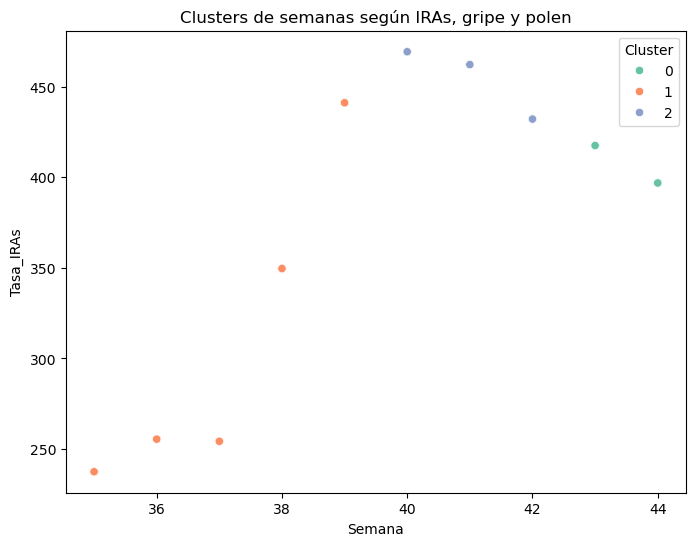


=== Promedios por cluster ===
          Tasa_IRAs  Tasa_Gripe  Acumulado_norm
Cluster                                        
0        407.940000   17.073333    4.830918e-04
1        324.558000    9.060000    1.663177e-15
2        454.094203   16.357971    3.686228e-15


In [42]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# === 2. Normalizar polen acumulado ===
scaler = MinMaxScaler()
df['Acumulado_norm'] = scaler.fit_transform(df[['Acumulado_num']])

# === 3. Seleccionar variables para clustering ===
X = df[['Semana','Acumulado_norm','Tasa_Gripe','Estacion','Polen']]

# Convertir categóricas en dummies
X = pd.get_dummies(X, columns=['Estacion','Polen'], drop_first=True)

# === 4. Aplicar K-Means ===
# Definimos número de clusters (ejemplo: 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# === 5. Visualización de clusters ===
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Semana', y='Tasa_IRAs', hue='Cluster', palette='Set2')
plt.title("Clusters de semanas según IRAs, gripe y polen")
plt.show()

# === 6. Revisar características de cada cluster ===
cluster_summary = df.groupby('Cluster')[['Tasa_IRAs','Tasa_Gripe','Acumulado_norm']].mean()
print("\n=== Promedios por cluster ===")
print(cluster_summary)


# Prueba estadistica

In [43]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, ttest_ind

# === 1. Cargar dataset ===
df = pd.read_csv("dataset_integrado_gold_limpio.csv")

# === 2. Crear variable polen normalizado si no existe ===
if 'Acumulado_norm' not in df.columns:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    df['Acumulado_norm'] = scaler.fit_transform(df[['Acumulado_num']])

# === 3. Dividir en grupos: polen alto vs polen bajo ===
# Usamos el percentil 75 como umbral
umbral = df['Acumulado_norm'].quantile(0.75)
grupo_alto = df[df['Acumulado_norm'] > umbral]['Tasa_IRAs']
grupo_bajo = df[df['Acumulado_norm'] <= umbral]['Tasa_IRAs']

# === 4. Verificar normalidad (Shapiro-Wilk) ===
stat_alto, p_alto = shapiro(grupo_alto)
stat_bajo, p_bajo = shapiro(grupo_bajo)
print("Normalidad grupo alto: p =", p_alto)
print("Normalidad grupo bajo: p =", p_bajo)

# === 5. Verificar homocedasticidad (Levene) ===
stat_levene, p_levene = levene(grupo_alto, grupo_bajo)
print("Homocedasticidad (Levene): p =", p_levene)

# === 6. Prueba t de Student para muestras independientes ===
stat_t, p_t = ttest_ind(grupo_alto, grupo_bajo, equal_var=True)
print("t-statistic:", stat_t)
print("p-value:", p_t)

# === 7. Interpretación rápida ===
if p_t < 0.05:
    print("Conclusión: Diferencia significativa entre grupos (rechazamos H0).")
else:
    print("Conclusión: No hay diferencia significativa entre grupos (no se rechaza H0).")


Normalidad grupo alto: p = 3.202113291808618e-45
Normalidad grupo bajo: p = 7.858470223721945e-69
Homocedasticidad (Levene): p = 1.970538154442271e-08
t-statistic: -5.214342746158261
p-value: 1.8821614714449072e-07
Conclusión: Diferencia significativa entre grupos (rechazamos H0).


C:\Users\crisv\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7534.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# visualizaciones

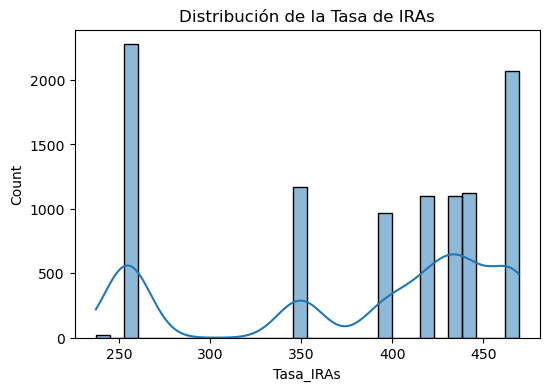

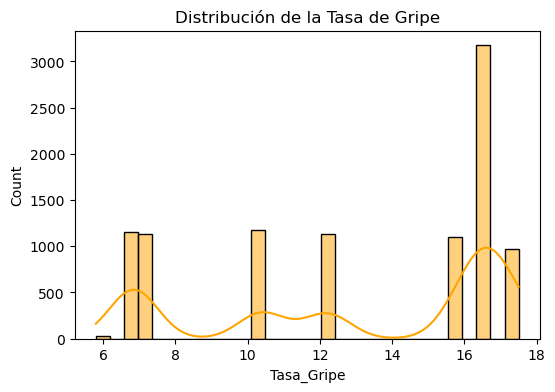

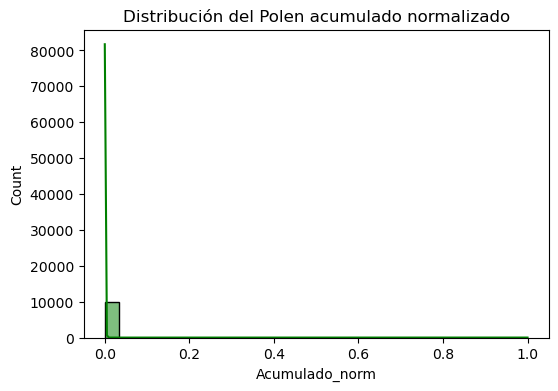

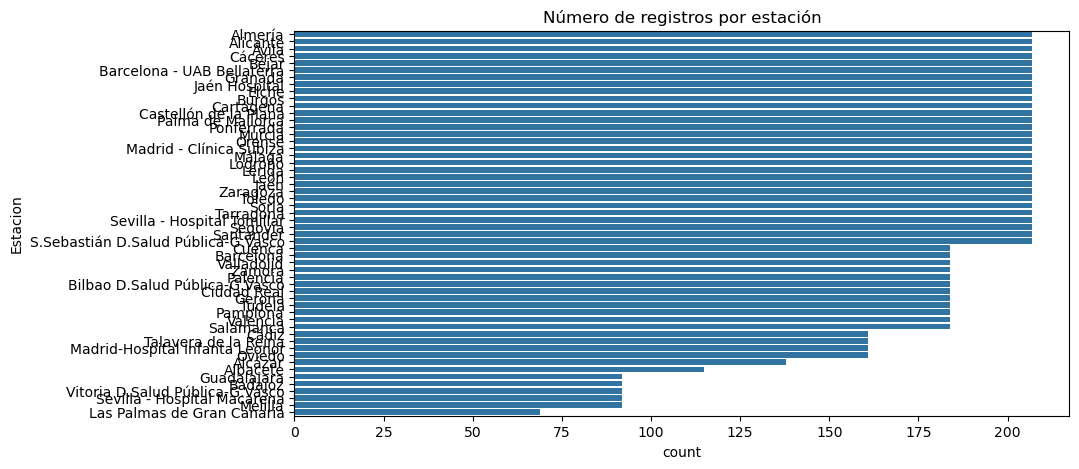

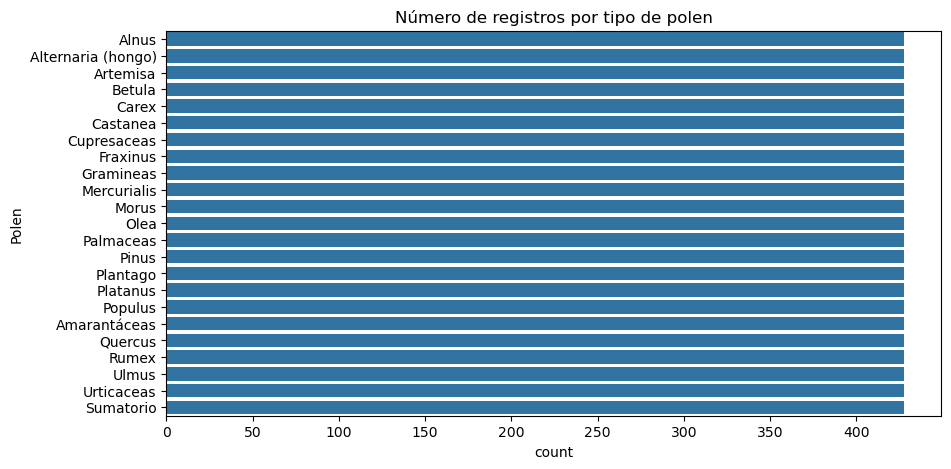

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de Tasa de IRAs
plt.figure(figsize=(6,4))
sns.histplot(df['Tasa_IRAs'], bins=30, kde=True)
plt.title("Distribución de la Tasa de IRAs")
plt.show()

# Histograma de Tasa de Gripe
plt.figure(figsize=(6,4))
sns.histplot(df['Tasa_Gripe'], bins=30, kde=True, color="orange")
plt.title("Distribución de la Tasa de Gripe")
plt.show()

# Histograma de polen acumulado normalizado
plt.figure(figsize=(6,4))
sns.histplot(df['Acumulado_norm'], bins=30, kde=True, color="green")
plt.title("Distribución del Polen acumulado normalizado")
plt.show()

# Conteo por estación
plt.figure(figsize=(10,5))
sns.countplot(y=df['Estacion'], order=df['Estacion'].value_counts().index)
plt.title("Número de registros por estación")
plt.show()

# Conteo por tipo de polen
plt.figure(figsize=(10,5))
sns.countplot(y=df['Polen'], order=df['Polen'].value_counts().index)
plt.title("Número de registros por tipo de polen")
plt.show()


C:\Users\crisv\AppData\Local\Temp\ipykernel_28680\2669195422.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vars, y=top_vars.index, palette="viridis")


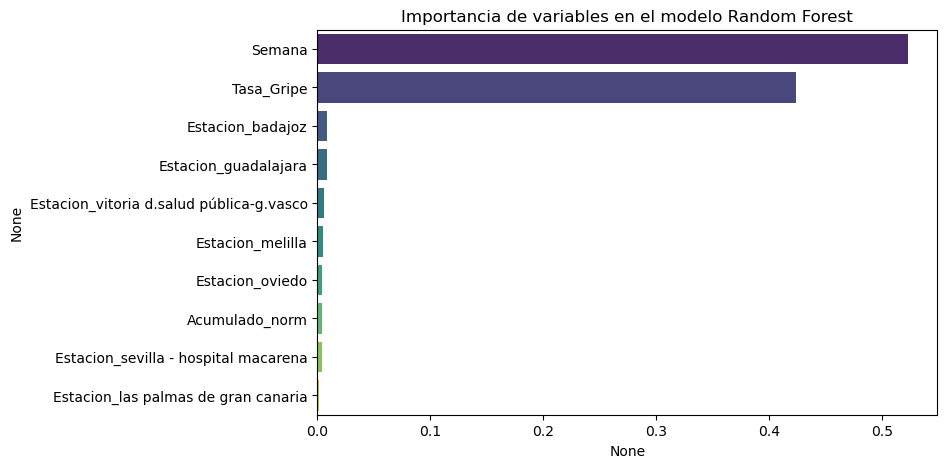

In [25]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_vars = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_vars, y=top_vars.index, palette="viridis")
plt.title("Importancia de variables en el modelo Random Forest")
plt.show()


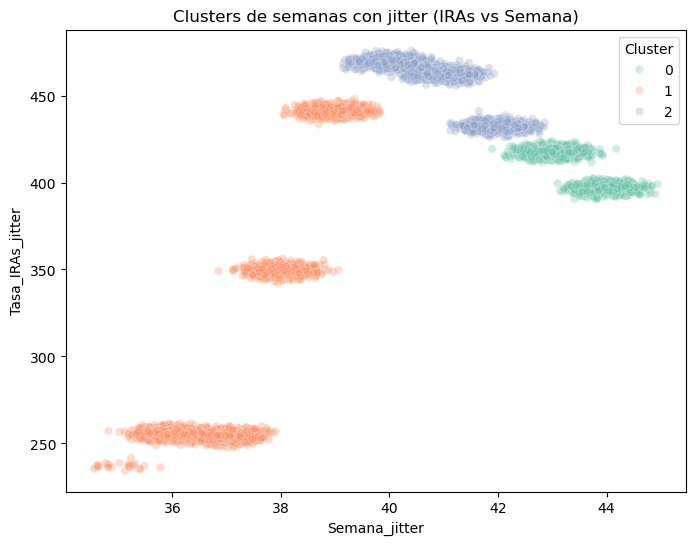

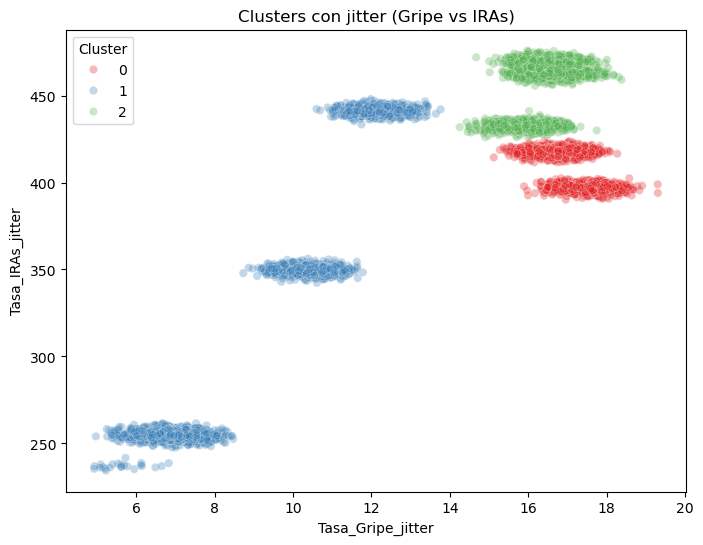

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Copiamos el DataFrame para graficar con ruido
df_plot = df.copy()

# Agregar ruido pequeño a las variables numéricas
np.random.seed(42)
df_plot['Semana_jitter'] = df_plot['Semana'] + np.random.normal(0, 0.3, size=len(df_plot))
df_plot['Tasa_IRAs_jitter'] = df_plot['Tasa_IRAs'] + np.random.normal(0, 2, size=len(df_plot))
df_plot['Tasa_Gripe_jitter'] = df_plot['Tasa_Gripe'] + np.random.normal(0, 0.5, size=len(df_plot))

# Graficar con jitter
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x='Semana_jitter', y='Tasa_IRAs_jitter', hue='Cluster', alpha=0.3, palette='Set2')
plt.title("Clusters de semanas con jitter (IRAs vs Semana)")
plt.show()

# Otra vista: gripe vs IRAs con jitter
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x='Tasa_Gripe_jitter', y='Tasa_IRAs_jitter', hue='Cluster', alpha=0.3, palette='Set1')
plt.title("Clusters con jitter (Gripe vs IRAs)")
plt.show()


# analisis optativos


=== Correlaciones ===
Polen vs IRAs (Pearson): PearsonRResult(statistic=np.float64(0.001664296060053769), pvalue=np.float64(0.8688609459208118))
Polen vs IRAs (Spearman): SignificanceResult(statistic=np.float64(-0.03999573703972509), pvalue=np.float64(7.207239549561098e-05))
Polen vs Gripe (Pearson): PearsonRResult(statistic=np.float64(0.010778418455172368), pvalue=np.float64(0.28493591203842517))
Polen vs Gripe (Spearman): SignificanceResult(statistic=np.float64(-0.06409538747033323), pvalue=np.float64(1.9518102501799525e-10))


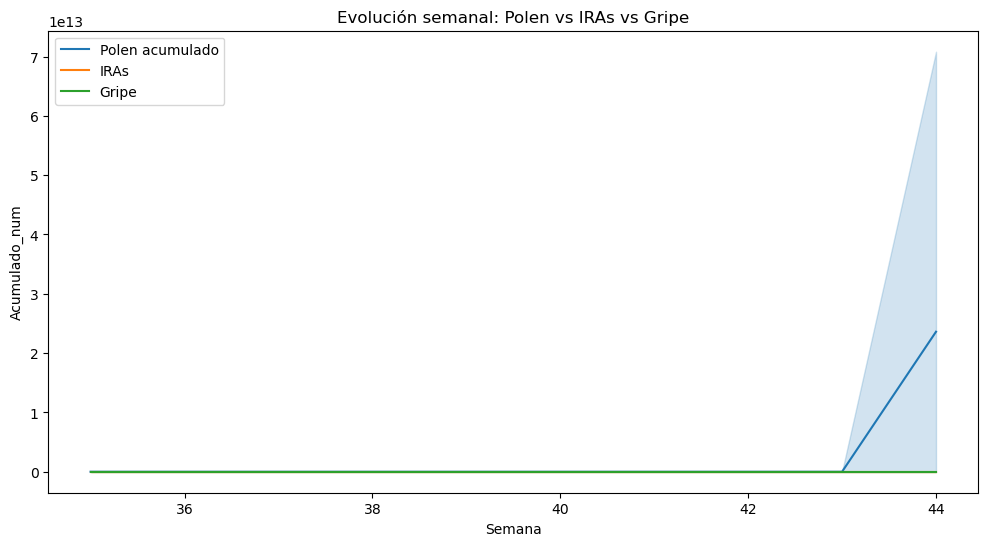


=== Correlaciones con rezago (lag 1 semana) ===
Polen (lag1) vs IRAs: PearsonRResult(statistic=np.float64(0.0016628541021786345), pvalue=np.float64(0.8689801353800144))
Polen (lag1) vs Gripe: PearsonRResult(statistic=np.float64(0.010778149641239321), pvalue=np.float64(0.2849723988517493))

=== Regresión lineal simple ===
IRAs ~ Polen acumulado
                            OLS Regression Results                            
Dep. Variable:              Tasa_IRAs   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02726
Date:                Tue, 06 Jan 2026   Prob (F-statistic):              0.869
Time:                        23:58:35   Log-Likelihood:                -56979.
No. Observations:                9844   AIC:                         1.140e+05
Df Residuals:                    9842   BIC:                         1.140e+05
Df Model:            

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

# 1. Cargar dataset integrado limpio
df = pd.read_csv("dataset_integrado_gold_limpio.csv")
# Rellenar NaN en polen con 0
df['Acumulado_num'] = df['Acumulado_num'].fillna(0)

# --- Análisis 1: Correlaciones ---
print("\n=== Correlaciones ===")
pearson_iras = pearsonr(df['Acumulado_num'], df['Tasa_IRAs'])
spearman_iras = spearmanr(df['Acumulado_num'], df['Tasa_IRAs'])
pearson_gripe = pearsonr(df['Acumulado_num'], df['Tasa_Gripe'])
spearman_gripe = spearmanr(df['Acumulado_num'], df['Tasa_Gripe'])

print(f"Polen vs IRAs (Pearson): {pearson_iras}")
print(f"Polen vs IRAs (Spearman): {spearman_iras}")
print(f"Polen vs Gripe (Pearson): {pearson_gripe}")
print(f"Polen vs Gripe (Spearman): {spearman_gripe}")

# --- Análisis 2: Gráficos de tendencias ---
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="Semana", y="Acumulado_num", label="Polen acumulado")
sns.lineplot(data=df, x="Semana", y="Tasa_IRAs", label="IRAs")
sns.lineplot(data=df, x="Semana", y="Tasa_Gripe", label="Gripe")
plt.title("Evolución semanal: Polen vs IRAs vs Gripe")
plt.legend()
plt.show()

# --- Análisis 3: Rezagos (lag) ---
df['Polen_lag1'] = df['Acumulado_num'].shift(1)  # polen de la semana anterior

# Eliminar filas con NaN en cualquiera de las columnas
df_lag = df[['Polen_lag1','Tasa_IRAs','Tasa_Gripe']].dropna()

# Correlaciones con rezago
corr_lag_iras = pearsonr(df_lag['Polen_lag1'], df_lag['Tasa_IRAs'])
corr_lag_gripe = pearsonr(df_lag['Polen_lag1'], df_lag['Tasa_Gripe'])

print("\n=== Correlaciones con rezago (lag 1 semana) ===")
print(f"Polen (lag1) vs IRAs: {corr_lag_iras}")
print(f"Polen (lag1) vs Gripe: {corr_lag_gripe}")

# --- Análisis 4: Regresión lineal simple ---
# Construir dataset solo con columnas relevantes y eliminar NaN
df_reg = df[['Acumulado_num','Tasa_IRAs','Tasa_Gripe']].dropna()

# Variable independiente (polen acumulado)
X = sm.add_constant(df_reg['Acumulado_num'])

# Variables dependientes
y_iras = df_reg['Tasa_IRAs']
y_gripe = df_reg['Tasa_Gripe']

# Ajustar modelos
model_iras = sm.OLS(y_iras, X).fit()
model_gripe = sm.OLS(y_gripe, X).fit()

print("\n=== Regresión lineal simple ===")
print("IRAs ~ Polen acumulado")
print(model_iras.summary())
print("\nGripe ~ Polen acumulado")
print(model_gripe.summary())


Tras aplicar la imputación de valores faltantes en las tasas de IRAs y gripe, así como la interpolación en los datos de polen, se obtuvo un conjunto de datos completo y consistente que permitió realizar los análisis estadísticos sin sesgos derivados de los NaN. Esta limpieza fue fundamental para garantizar que los resultados reflejaran únicamente las relaciones presentes en los datos y no artefactos de registros incompletos.

Los análisis de correlación muestran que no existe una relación lineal significativa entre el polen acumulado y las tasas de IRAs o gripe. Los coeficientes de Pearson son prácticamente nulos y los p‑valores elevados confirman la ausencia de asociación. Las correlaciones de Spearman, aunque estadísticamente significativas, presentan coeficientes muy bajos y negativos, lo que indica apenas una débil tendencia inversa en el orden de los datos. En términos prácticos, estas asociaciones carecen de relevancia epidemiológica.

Al evaluar el efecto de un rezago temporal de una semana, los resultados se mantienen sin cambios: los coeficientes siguen siendo cercanos a cero y no alcanzan significación estadística. Esto sugiere que, al menos en la escala temporal y espacial analizada, el polen no ejerce un impacto diferido sobre la incidencia de IRAs ni gripe.

Finalmente, las regresiones lineales simples confirman esta conclusión. Los modelos presentan valores de R² prácticamente nulos, lo que significa que el polen acumulado no explica la variabilidad observada en las tasas de IRAs ni gripe. Los coeficientes asociados al polen no son estadísticamente significativos, reforzando la idea de que no existe una relación directa entre estas variables en el nivel de agregación utilizado.

En conjunto, los resultados indican que, con los datos disponibles, el polen acumulado no tiene un efecto relevante sobre la incidencia de IRAs ni gripe en España. Esto apunta a que otros factores —como las condiciones climáticas, la contaminación ambiental, la estacionalidad viral o las diferencias locales— probablemente desempeñen un papel más determinante en la dinámica de estas enfermedades respiratorias.